# Import Libs

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from torch.optim import AdamW
from utils import SklearnWrapper, verify_scaling
from pypfopt import risk_models, expected_returns, plotting

In [2]:
from config import *
from entities import *
from components import *
from strategies import *
from datasets import *
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

## Config

In [3]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Data

In [9]:
symbols = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'GOOG', 'META', 'AVGO', 'ORCL', 'CRM', 'ADBE', 'AMD', 'CSCO']
freq = "1d"
# Basket
basket = Basket(symbols=symbols)
basket.load_all_assets(freq=freq)

DEBUG:entities.basket:Initialized Asset Basket: ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'GOOG', 'META', 'AVGO', 'ORCL', 'CRM', 'ADBE', 'AMD', 'CSCO'] with 0 assets which loaded.
INFO:entities.basket:Starting batch load for 14 symbols...
DEBUG:entities.basket:Attempting to load AAPL...
DEBUG:entities.asset:Initialized Asset: AAPL with 2724 rows.
INFO:entities.basket:Successfully loaded AAPL (2724 rows).
DEBUG:entities.basket:Attempting to load TSLA...
DEBUG:entities.asset:Initialized Asset: TSLA with 2760 rows.
INFO:entities.basket:Successfully loaded TSLA (2760 rows).
DEBUG:entities.basket:Attempting to load MSFT...
DEBUG:entities.asset:Initialized Asset: MSFT with 2724 rows.
INFO:entities.basket:Successfully loaded MSFT (2724 rows).
DEBUG:entities.basket:Attempting to load NVDA...
DEBUG:entities.asset:Initialized Asset: NVDA with 2724 rows.
INFO:entities.basket:Successfully loaded NVDA (2724 rows).
DEBUG:entities.basket:Attempting to load GOOGL...
DEBUG:entities.asset:Initia

## Align Data (Align FT)
$\text{Align}(FT) \to FT_{\text{aligned}}$
1. We must find Joint Distribution $FT_{\text{date\ A}} \cap FT_{\text{date\ B}}$

2. Other plan

In [15]:
targets = ["Close"]
print(basket.get_unique_features())

['Close', 'High', 'Low', 'Open', 'Volume']


In [11]:
print(f"Basket data shape: {basket.data.shape}")

strategy = IntersectionStrategy()
basket.align(strategy)

print(f"Basket data shape: {basket.data.shape}")

INFO:strategies.concrete:Aligned: 14 orig -> 14 clean assets -> 1464 rows
DEBUG:entities.basket:Aligned data shape: (1464, 70)
INFO:entities.basket:Assets updated in-place to aligned index (Length: 1464)


Basket data shape: (2760, 70)
Basket data shape: (1464, 70)


## Data Stats (Portfolio optimization) by PyPortfolioOpt lib
ref: https://medium.com/qunt-i-love-u/python-library-%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%80%E0%B8%81%E0%B8%B4%E0%B8%94%E0%B8%A1%E0%B8%B2%E0%B9%80%E0%B8%9E%E0%B8%B7%E0%B9%88%E0%B8%AD%E0%B8%97%E0%B8%B3-portfolio-optimization-b07398e2e228

In [13]:
gt_sampling = basket.data.xs(key="Close",level=1, axis=1)
gt_sampling.head(5)

,AAPL,TSLA,MSFT,NVDA,GOOGL,AMZN,GOOG,META,AVGO,ORCL,CRM,ADBE,AMD,CSCO
Date,,,,,,,,,,,,,,
2020-01-02,72.538536,28.684000,152.791092,5.971409,67.920807,94.900497,67.903816,208.324768,27.788618,49.451618,165.251709,334.429993,49.099998,40.688908
2020-01-03,71.833290,29.534000,150.888641,5.875832,67.565491,93.748497,67.570595,207.222504,27.081818,49.277462,164.440247,331.809998,48.599998,40.025055
2020-01-06,72.405701,30.102667,151.278625,5.900472,69.366394,95.143997,69.236694,211.125229,27.041304,49.534111,171.644440,333.709991,48.389999,40.167908
2020-01-07,72.065147,31.270666,149.899307,5.971908,69.232399,95.343002,69.193497,211.582031,26.948212,49.644108,174.167892,333.390015,48.250000,39.907402
2020-01-08,73.224419,32.809334,152.286972,5.983109,69.725182,94.598503,69.738770,213.727066,26.612051,49.837460,175.484070,337.869995,47.830002,39.932617


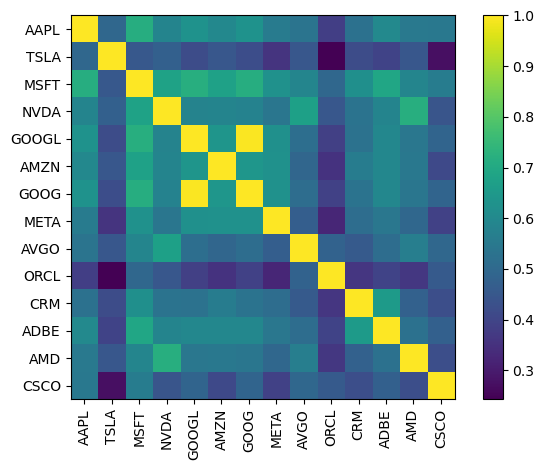

In [14]:
gt_sampling_cov = risk_models.sample_cov(gt_sampling)
plotting.plot_covariance(gt_sampling_cov, plot_correlation=True)
plt.show()

### Exponential covariance

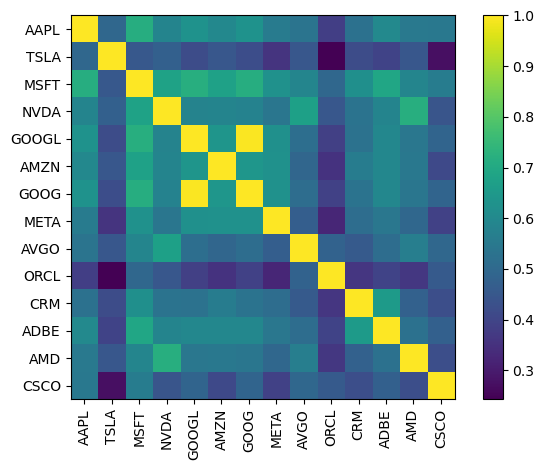

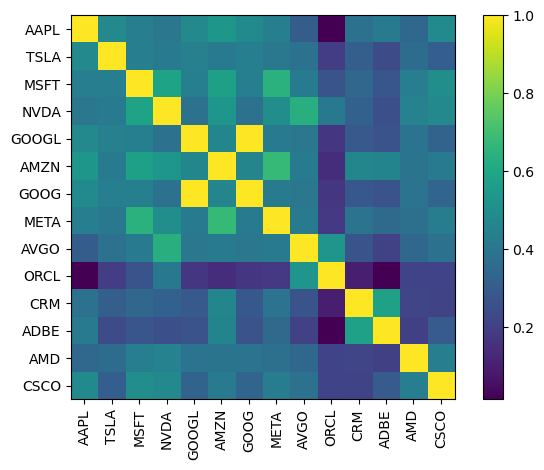

In [16]:
gt_sampling_exp_cov = risk_models.exp_cov(gt_sampling)
plotting.plot_covariance(gt_sampling_cov, plot_correlation=True)
plotting.plot_covariance(gt_sampling_exp_cov, plot_correlation=True)
plt.show()

### We applied both shrinkage methods to compare their results.

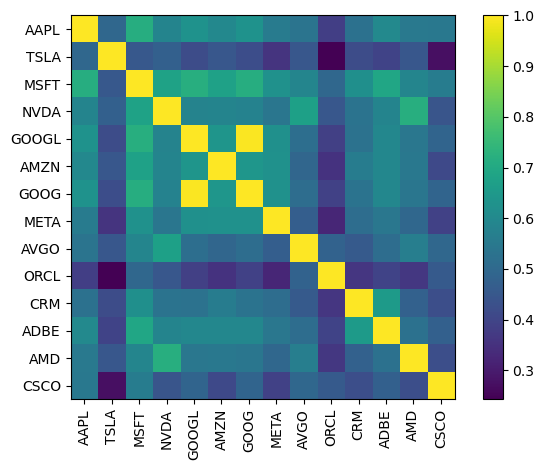

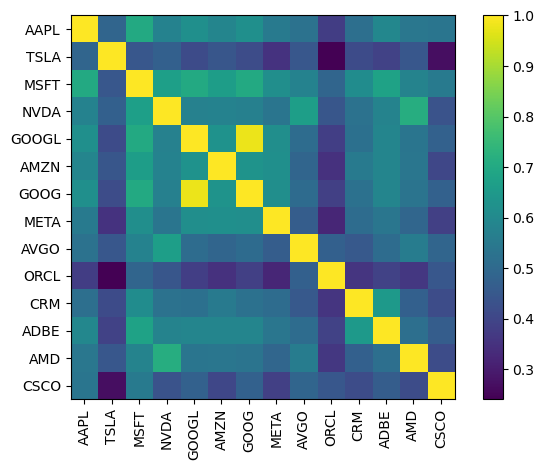

In [18]:
gt_sampling_cov_shrinkage = risk_models.CovarianceShrinkage(gt_sampling).ledoit_wolf()
plotting.plot_covariance(gt_sampling_cov, plot_correlation=True)
plotting.plot_covariance(gt_sampling_cov_shrinkage, plot_correlation=True)
plt.show()

### Select Features for norm to Returns 
$ \|FT\| \to FT_{\text{returns}} $

In [16]:
basket.to_returns(features=targets, log=True, keep=False)

what_ft_has()
basket.data.head(5)

DEBUG:entities.asset:AAPL converted to Returns (log=True)
DEBUG:entities.asset:TSLA converted to Returns (log=True)
DEBUG:entities.asset:MSFT converted to Returns (log=True)
DEBUG:entities.asset:NVDA converted to Returns (log=True)
DEBUG:entities.asset:GOOGL converted to Returns (log=True)
DEBUG:entities.asset:AMZN converted to Returns (log=True)
DEBUG:entities.asset:GOOG converted to Returns (log=True)
DEBUG:entities.asset:META converted to Returns (log=True)
DEBUG:entities.asset:AVGO converted to Returns (log=True)
DEBUG:entities.asset:ORCL converted to Returns (log=True)
DEBUG:entities.asset:CRM converted to Returns (log=True)
DEBUG:entities.asset:ADBE converted to Returns (log=True)
DEBUG:entities.asset:AMD converted to Returns (log=True)
DEBUG:entities.asset:CSCO converted to Returns (log=True)


['Close (Log_Returns)', 'High', 'Low', 'Open', 'Volume']


AAPL                                                         \
                 High        Low       Open       Volume Close (Log_Returns)   
Date                                                                           
2015-01-05  24.110150  23.391173  24.030263  257142000.0           -0.028576   
2015-01-06  23.839424  23.218085  23.641928  263188400.0            0.000094   
2015-01-07  24.010290  23.677430  23.788384  160423600.0            0.013925   
2015-01-08  24.886815  24.121236  24.238848  237458000.0            0.037702   
2015-01-09  25.130917  24.456320  25.002210  214798000.0            0.001072   

                 TSLA                                                      \
                 High        Low       Open    Volume Close (Log_Returns)   
Date                                                                        
2015-01-05  14.433333  13.810667  14.303333  80527500           -0.042950   
2015-01-06  14.280000  13.614000  14.004000  93928500            0.005648   
2015-01-07  14.318667  13.985333  14.223333  44526000           -0.001563   
2015-01-08  14.253333  14.000667  14.187333  51637500           -0.001566   
2015-01-09  13.998667  13.664000  13.928000  70024500           -0.018981   

            ...   AMD                                                   CSCO  \
            ...  High   Low  Open      Volume Close (Log_Returns)       High   
Date        ...                                                                
2015-01-05  ...  2.70  2.64  2.67   8878200.0           -0.003752  19.700776   
2015-01-06  ...  2.66  2.55  2.65  13912500.0           -0.011342  19.865848   
2015-01-07  ...  2.65  2.54  2.63  12377600.0           -0.019195  19.664896   
2015-01-08  ...  2.65  2.56  2.59  11136600.0            0.011561  20.160107   
2015-01-09  ...  2.64  2.58  2.63   8907600.0            0.007634  20.145750   

                                                                  
                  Low       Open      Volume Close (Log_Returns)  
Date                                                              
2015-01-05  19.377812  19.607475  29460600.0           -0.020121  
2015-01-06  19.406522  19.478291  47297600.0           -0.000370  
2015-01-07  19.363463  19.478295  27570800.0            0.009200  
2015-01-08  19.715135  19.765374  40907000.0            0.007663  
2015-01-09  19.700779  19.858671  33619600.0            0.010127  

[5 rows x 70 columns]

### Select Feature to tensor
* std, mean, max require dim = Time (T)
* cov, corr require dim = Assets, Time (N, T)

In [8]:
targets = ["Close (Log_Returns)"]
basket_tensor = basket.to_tensor(features=targets)

print(f"Basket Tensor Shape: {basket_tensor.shape}")
print(verify_scaling(basket_tensor))

DEBUG:entities.asset:Asset: AAPL is using cuda device.
DEBUG:entities.asset:Asset: TSLA is using cuda device.
DEBUG:entities.asset:Asset: MSFT is using cuda device.
DEBUG:entities.asset:Asset: NVDA is using cuda device.
DEBUG:entities.asset:Asset: GOOGL is using cuda device.
DEBUG:entities.asset:Asset: AMZN is using cuda device.
DEBUG:entities.asset:Asset: GOOG is using cuda device.
DEBUG:entities.asset:Asset: META is using cuda device.
DEBUG:entities.asset:Asset: AVGO is using cuda device.
DEBUG:entities.asset:Asset: ORCL is using cuda device.
DEBUG:entities.asset:Asset: CRM is using cuda device.
DEBUG:entities.asset:Asset: ADBE is using cuda device.
DEBUG:entities.asset:Asset: AMD is using cuda device.
DEBUG:entities.asset:Asset: CSCO is using cuda device.


Basket Tensor Shape: torch.Size([1463, 14, 1])
--- Global Stats ---
Max: 0.3071
Min: -0.3064
Mean: 0.0010
Std: 0.0263
None


In [9]:
basket_tensor_stats = basket_tensor.squeeze(-1)

# Portfolio Optimization
We must use price for calc

In [43]:
pfopt_sample = basket.data.xs(key="Close (Log_Returns)", level=1, axis=1)
pfopt_sample = pfopt_sample.dropna(axis=0)
pfopt_sample.head(5)

,AAPL,TSLA,MSFT,NVDA,GOOGL,AMZN,GOOG,META,AVGO,ORCL,CRM,ADBE,AMD,CSCO
Date,,,,,,,,,,,,,,
2020-01-03,-0.009770,0.029203,-0.012529,-0.016135,-0.005245,-0.012213,-0.004919,-0.005305,-0.025764,-0.003528,-0.004923,-0.007865,-0.010236,-0.016450
2020-01-06,0.007937,0.019072,0.002581,0.004185,0.026305,0.014776,0.024358,0.018658,-0.001497,0.005195,0.042878,0.005710,-0.004330,0.003563
2020-01-07,-0.004715,0.038067,-0.009160,0.012034,-0.001934,0.002089,-0.000624,0.002161,-0.003449,0.002218,0.014595,-0.000959,-0.002897,-0.006507
2020-01-08,0.015958,0.048033,0.015803,0.001874,0.007093,-0.007839,0.007850,0.010087,-0.012553,0.003887,0.007529,0.013348,-0.008743,0.000632
2020-01-09,0.021018,-0.022189,0.012415,0.010923,0.010443,0.004788,0.010984,0.014209,-0.008065,0.004608,0.012720,0.007607,0.023555,-0.004218


In [47]:
pfopt_sample.isna().any()

AAPL     False
TSLA     False
MSFT     False
NVDA     False
GOOGL    False
AMZN     False
GOOG     False
META     False
AVGO     False
ORCL     False
CRM      False
ADBE     False
AMD      False
CSCO     False
dtype: bool

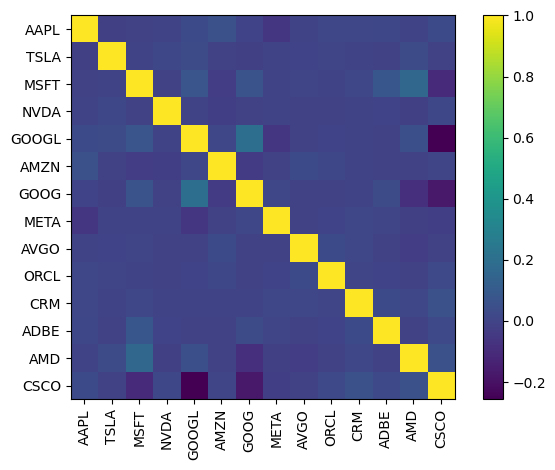

In [48]:
from pypfopt import risk_models, expected_returns, plotting

sample_cov = risk_models.sample_cov(pfopt_sample)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plt.show()

In [50]:
# exp_cov = risk_models.exp_cov(pfopt_sample)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(sample_cov, plot_correlation=True)
# plt.show()